In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from analysis_count import read_n, classify_imgs2
import matplotlib.pyplot as plt
%matplotlib inline

['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/count_log.csv', 'model_runs/-f/countmodel_0.ckpt', 'model_runs/-f/countmodel_', 'true', 'false', 'false', 'true']
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
analysis_count.py


In [2]:
model_name = "1127_5blobs"
num_runs = 1
iter_list = [0, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 600000]#, 1000000, 1350000]
#iter_list = np.arange(0,11100000,100000)
glimpse_list = np.arange(0,6,1)
max_blobs = 5
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
blob_list = np.arange(0,6,1)
output_size = max_blobs - min_blobs + 2 # 6
data_directory = "data/" + model_name + "/"
m = 0.5

confidence_all_runs = np.zeros([num_runs, num_iters, output_size-1, num_glimpses, 1, output_size]) 
choice_all_runs = np.zeros([num_runs, num_iters, output_size-1, num_glimpses, 1, output_size])

In [3]:
def fill_matrix(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 100 # batch_size
    imgs_data = classify_imgs2(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size-1, num_glimpses, 1, output_size])
    choice_one_run = np.zeros([output_size-1, num_glimpses, 1, output_size])
    
    for nb in range(output_size-1):
        confidence_hist = np.zeros([num_glimpses, 1, output_size])
        choice_hist = np.zeros([num_glimpses, 1, output_size])
        num_imgs_with_num_blobs = 0.00001
        
        for idx, data in enumerate(imgs_data):
            if data["label"][nb] == 1: # data is for an image with nb+1 blobs
                num_imgs_with_num_blobs += 1
                
                for g, glimpse in enumerate(glimpse_list):
                    # Histogram of softmaxes
                    confidence_hist[glimpse] += data["classifications"][glimpse]
                    # Histogram of choices
                    choice = np.argmax(data["classifications"][glimpse])
                    choice_list = [0] * (output_size)
                    choice_list[choice] = 1
                    choice_hist[glimpse] += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()
        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
    return confidence_one_run, choice_one_run

In [4]:
for run in range(num_runs):
    path = 'model_runs/' + model_name # '_run_' + str(run + 1) 
#     path = 'model_runs/DRAM_test_square'
    for i, iteration in enumerate(iter_list):
        confidence_all_runs[run, i], choice_all_runs[run, i] = fill_matrix(path, iteration)

INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_1000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_4000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_16000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_32000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_64000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_125000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_250000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_500000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/1127_5blobs/countmodel_600000.ckpt


In [5]:
def adj_all_runs(all_runs_matrix):
    """Adjust all the matrices so tick marks start with 1."""
    
    new_all_runs_matrix = np.zeros([num_runs, num_iters, output_size-1, num_glimpses+1, 1, output_size])
    for m, matrix in enumerate(all_runs_matrix):
        for i in range(num_iters):
            for g in range(num_glimpses):
                new_all_runs_matrix[m, i, g] = adj_matrix(matrix[i, g])
    return new_all_runs_matrix


def adj_matrix(matrix):
    """Adjust the matrix so tick marks start with 1."""
    
    a = np.zeros([1, output_size])
    temp = np.vstack((a, matrix))
    b = np.zeros([output_size + 1, 1])
    new_matrix = np.hstack((b, temp))
    return new_matrix


confidence_all_runs_adj = confidence_all_runs#adj_all_runs(confidence_all_runs)
choice_all_runs_adj = choice_all_runs#adj_all_runs(choice_all_runs)

In [6]:
confidence_avg = np.mean(confidence_all_runs_adj, axis=0)
choice_avg = np.mean(choice_all_runs_adj, axis=0)
confidence_avg[5,0,0,0]

array([  5.08148820e-06,   9.99976428e-01,   1.80471076e-05,
         6.32633828e-09,   1.03140590e-09,   1.09029494e-08])

In [7]:
def plot_confidence(iter_idx, it, num_blobs, run=None):
    """Plot the confidence heatmap."""
    
    if run is None:
        matrix = np.zeros([6,6])
        for g in range (6):
            matrix[:,g] = confidence_avg[iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Confidence after %d Iters" % (num_blobs+1, it)

    else:
        matrix = np.zeros([6,6])
        for g in range (6):
            matrix = confidence_all_runs_adj[run, iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Confidence at Run %d after %d Iters" % (num_blobs+1, run + 1, it)
    plot_heatmap(matrix, num_blobs, plot_title)


def plot_choice(iter_idx, it, num_blobs, run=None):
    """Plot the choice heatmap."""
    
    if run is None:
        matrix = np.zeros([6,6])
        for g in range (6):
            matrix[:,g] = choice_avg[iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Choice after %d Iterations" % (num_blobs+1, it)
    else:
        matrix = np.zeros([6,6])
        for g in range (6):
            matrix = choice_all_runs_adj[run, iter_idx, num_blobs, g, 0]
        plot_title = "%d Blobs:Choice at Run %d after %d Iterations" % (num_blobs+1, run + 1, it)
    plot_heatmap(matrix, num_blobs, plot_title)
    
    
def plot_heatmap(matrix, num_blobs, plot_title):
    """Plot heatmap."""
    
    data = [go.Heatmap(
        z=matrix,
        colorscale="Jet"
    )]

    layout = go.Layout(
        title=plot_title,
        yaxis=dict(
#             range=[max_blobs + m, min_blobs - m],
            range=[0 - m, 5 + m],
            title="Count Word",
            dtick=1,
            tickcolor='#FFF'
        ),
        xaxis=dict(
            range=[0 - m, 5 + m],
            title="Glimpses",
            dtick=1,
            tickcolor='#FFF'
        ),
        width=300,
        height=300,
        plot_bgcolor="#000",
        paper_bgcolor="#000",
        font=dict(
            color="#FFF"
        ),
        titlefont=dict(
            color="#FFF"
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [8]:
for n, num in enumerate(blob_list):
    for i, it in enumerate(iter_list):
        plot_confidence(i, it, num)
        #plot_choice(i, it, num)

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
iter_list= [600000]
for n, num in enumerate(blob_list): 
    for i, it in enumerate(iter_list):
        plot_confidence(i, it, num)
    #plot_choice(i, it, num)

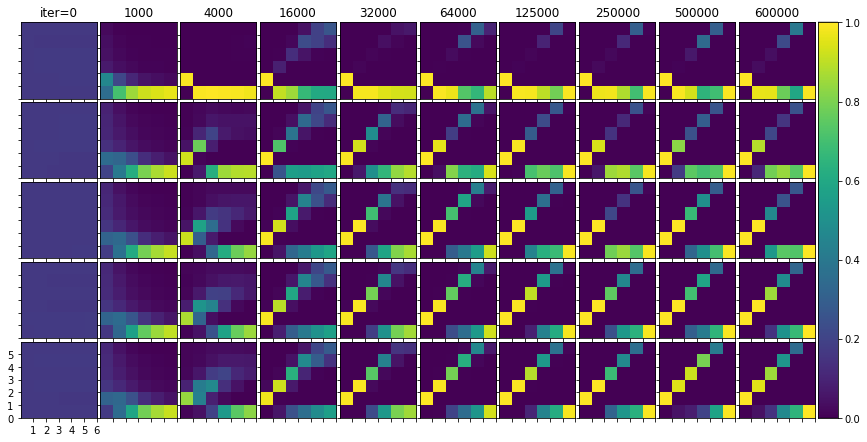

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

F = plt.figure(1, (16,16))
F.clf()

ZS = np.zeros([num_iters*(output_size-1),6,6])
extent = (0, 6, 0, 6) 
    
matrix = np.zeros([6, 6])
for num_blobs in range (output_size-1):
    for iter_idx in range (num_iters):
        for g in range (6):
            matrix[:,g] = confidence_avg[iter_idx, num_blobs, g, 0]
            ZS[iter_idx+num_iters*num_blobs] = matrix

extent = extent[0], extent[1], extent[2], extent[3] 

grid = ImageGrid(F, 212,
                 nrows_ncols=(output_size-1, num_iters),
                 direction="row",
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="1",
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.05,
                 )

grid[0].set_xlabel("Glimpse")
grid[0].set_ylabel("Count Word")

vmax, vmin = np.max(ZS), np.min(ZS)
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

for ax, im_title in zip(grid, ["iter=0", "1000", "4000", "16000", "32000", "64000", "125000", "250000", "500000", "600000"]):
    ax.set_title(im_title)
    ax.patch.set_alpha(0.5)
        
for ax, z in zip(grid, ZS):
    im = ax.imshow(z, norm=norm,
                   origin="lower", extent=extent,
                   interpolation="nearest")

# With cbar_mode="single", cax attribute of all axes are identical.
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

grid[0].set_xticks([1,2,3,4,5,6])
grid[0].set_yticks([0,1,2,3,4,5])
plt.draw()
plt.show()

